In [2]:
from wasserstein.texture_mixing_new import compute_texture_mixing 
from utils.image_treatment import preprocess_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_path1 = 'data/smallRed.jpg'
image_path2 = 'data/PebbleGround.png'

In [3]:
image1 = preprocess_image(image_path1, new_size = (200,200))
image2 = preprocess_image(image_path2, new_size = (200,200))

In [4]:
textures = [image1, image2]
rho = [0.2, 0.4, 0.6, 0.8]
final_texture = []
for r in rho:
    final_texture.append(compute_texture_mixing(textures, [1-r, r], num_scales = 4, num_orientations = 4))

100%|██████████| 18/18 [02:29<00:00,  8.33s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original $f^2$')

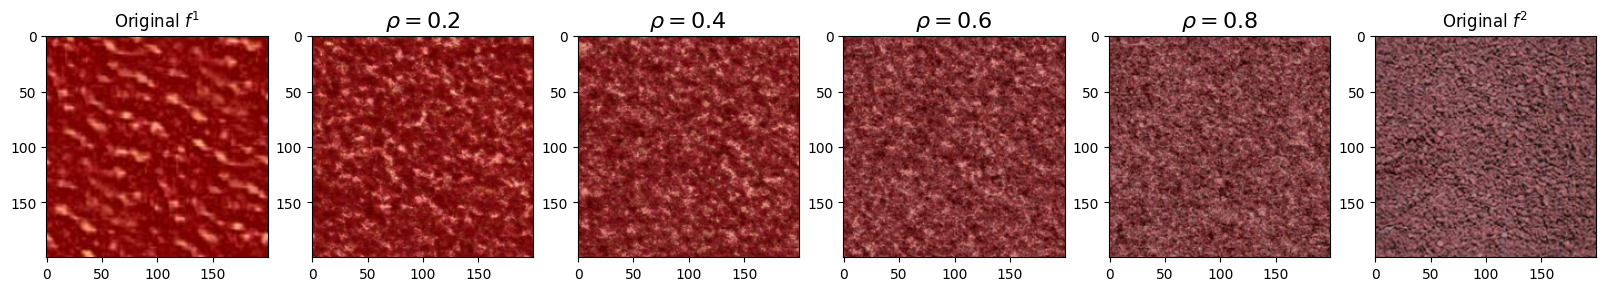

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(1,6,1)
plt.imshow(image1)
plt.title('Original $f^1$')
for i in range(len(final_texture)):
    plt.subplot(1,6,i+2)
    plt.imshow(final_texture[i])
    plt.title(f'$\\rho = {rho[i]}$', fontsize=16)
plt.subplot(1,6,6)
plt.imshow(image2)
plt.title('Original $f^2$')

In [3]:
#exemple où ça marche moins bien
image_path3 = 'data/gridBW.gif'
image_path4 = 'data/text3.gif'
image3 = preprocess_image(image_path3, new_size = (200,200))
image4 = preprocess_image(image_path4, new_size = (200,200))

textures = [image3, image4]
rho = [0.2, 0.4, 0.6, 0.8]
final_texture = []
for r in rho:
    final_texture.append(compute_texture_mixing(textures, [1-r, r], num_scales = 4, num_orientations = 4))

100%|██████████| 18/18 [02:34<00:00,  8.57s/it]


Text(0.5, 1.0, 'Original $f^2$')

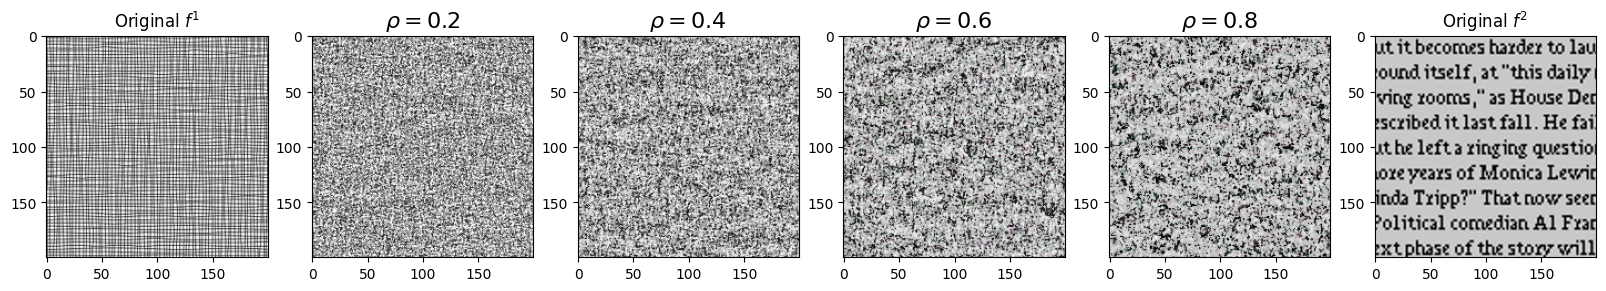

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(1,6,1)
plt.imshow(image3)
plt.title('Original $f^1$')
for i in range(len(final_texture)):
    plt.subplot(1,6,i+2)
    plt.imshow(final_texture[i])
    plt.title(f'$\\rho = {rho[i]}$', fontsize=16)
plt.subplot(1,6,6)
plt.imshow(image4)
plt.title('Original $f^2$')